In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def compression(input_video_path, scale_factor = 0.2):

    video_capture = cv2.VideoCapture(input_video_path)

    if not video_capture.isOpened():
        print("Error: Could not open video file.")
        return

    frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_capture.get(cv2.CAP_PROP_FPS)

    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    bitrate_array = np.zeros(total_frames)

    # Read and process each frame to calculate the total data size and bitrate
    # ISSUE - this assumes a constant bitrate, it does not actually get the per-frame bitrate
    frame_index = 0
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        frame_size = frame_width * frame_height * 3  # Assuming 3 bytes per pixel for a color image
        frame_duration = 1 / fps
        frame_bitrate_bps = (frame_size * 8) / frame_duration # Check calculation 
        frame_bitrate_kbps = frame_bitrate_bps / 1000
        bitrate_array[frame_index] = frame_bitrate_kbps
        frame_index += 1

    print(f"Original bitrates: {bitrate_array[:5]}")

    video_capture.release()

    video = cv2.VideoCapture(input_video_path)

    # Check if the video file was successfully opened
    if not video.isOpened():
        print("Error: Could not open video file")
        exit()

    colour_depth_complexities = []
    brightness_complexities = []
    motion_complexities = [0] # As this is a difference between 2 frames, it will be 1 shorter than the per-frame lists

    frames = []

    # Loop to read frames from the video and calculate complexity scores
    prev_frame = None

    while True:
        ret, frame = video.read()

        if not ret:
            break

        frames.append(frame)

        # Colour depth complexity
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        variance = np.var(gray_frame)
        colour_depth_complexity = variance / (255**2)
        colour_depth_complexities.append(colour_depth_complexity)

        # Brightness complexity
        brightness_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        mean_brightness = np.mean(brightness_frame) / 255 
        brightness_complexities.append(mean_brightness)

        # Motion complexity
        if prev_frame is not None:
            prev_gray_frame = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
            frame_diff = cv2.absdiff(prev_gray_frame, gray_frame)
            frame_diff = cv2.GaussianBlur(frame_diff, (5, 5), 0)
            _, thresholded_diff = cv2.threshold(frame_diff, 30, 255, cv2.THRESH_BINARY)

            motion_percentage = (np.count_nonzero(thresholded_diff) / (thresholded_diff.shape[0] * thresholded_diff.shape[1]))
            motion_complexities.append(motion_percentage)

        prev_frame = frame

    video.release()

    print('Frame complexities calculated.')

    complexity_df = pd.DataFrame({'Colour Depth Complexity': colour_depth_complexities,
                            'Brightness Complexity': brightness_complexities,
                            'Motion Complexity': motion_complexities})
    
    complexity_df.at[0, 'Motion Complexity'] = round(complexity_df['Motion Complexity'].mean())

    complexity_df['Average'] = complexity_df.mean(axis=1)
    complexity_df['Previous Bitrate'] = bitrate_array

    max_average = complexity_df['Average'].max()
    min_average = complexity_df['Average'].min()

    # Scale the bitrate so that the highest complexity bitrate stays the same and the lowest reduces by the scale factor
    min_average = complexity_df['Average'].min()
    max_average = complexity_df['Average'].max()

    total_magnitude_previous = complexity_df['Previous Bitrate'].sum()
    total_magnitude_scaled = total_magnitude_previous * (1 - scale_factor)

    # Calculate the scaling factor for each row based on 'Average'
    complexity_df['Scaling Factor'] = ((complexity_df['Average'] - min_average) / (max_average - min_average) * scale_factor)

    # Calculate 'Scaled Bitrate' based on the scaling factor
    complexity_df['Scaled Bitrate'] = round(complexity_df['Previous Bitrate'] * complexity_df['Scaling Factor'])
    complexity_df.at[0, 'Scaled Bitrate'] = round(complexity_df['Scaled Bitrate'].mean())

    new_bitrates = complexity_df['Scaled Bitrate'].values

    print(f'New bitrates calculated using scale factor {scale_factor}.')
    print(f"New bitrates: {new_bitrates[:5]}")

    output_video_path = f"output_videos/output_{round(100*scale_factor)}_{input_video_path}"

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' for MP4 codec
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    # Set the initial bitrate (first frame)
    current_bitrate = new_bitrates[0]

    # Iterate through the frames and write each frame to the video file
    for frame, bitrate in zip(frames, new_bitrates):
        if bitrate != current_bitrate:
            out.set(cv2.CAP_PROP_BITRATE, bitrate)
            current_bitrate = bitrate

        out.write(frame)

    out.release()

    print(f'Finshed: Video written to {output_video_path}')

    return complexity_df


In [3]:
def check(original_video, new_video):
    video_capture = cv2.VideoCapture(original_video)

    if not video_capture.isOpened():
        print("Error: Could not open video file.")
        return

    frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_capture.get(cv2.CAP_PROP_FPS)

    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    bitrate_array = np.zeros(total_frames)

    # Read and process each frame to calculate the total data size and bitrate
    frame_index = 0
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        frame_size = frame_width * frame_height * 3  # Assuming 3 bytes per pixel for a color image
        frame_duration = 1 / fps
        frame_bitrate_bps = (frame_size * 8) / frame_duration
        frame_bitrate_kbps = frame_bitrate_bps / 1000
        bitrate_array[frame_index] = frame_bitrate_kbps
        frame_index += 1

    video_capture.release()

    comparison_df = pd.DataFrame({"Old Bitrate": bitrate_array})

    # New Video
    video_capture = cv2.VideoCapture(new_video)

    if not video_capture.isOpened():
        print("Error: Could not open video file.")
        return

    frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_capture.get(cv2.CAP_PROP_FPS)

    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    new_bitrate_array = np.zeros(total_frames)

    # Read and process each frame to calculate the total data size and bitrate
    frame_index = 0
    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        frame_size = frame_width * frame_height * 3  # Assuming 3 bytes per pixel for a color image
        frame_duration = 1 / fps
        frame_bitrate_bps = (frame_size * 8) / frame_duration
        frame_bitrate_kbps = frame_bitrate_bps / 1000
        new_bitrate_array[frame_index] = frame_bitrate_kbps
        frame_index += 1

    video_capture.release()

    comparison_df['New Bitrates'] = new_bitrate_array

    if (comparison_df['New Bitrates'] == comparison_df['Old Bitrate']).all():
        print("There is no change in the bitrates")
    else:
        print('The bitrates do change')
    return comparison_df

In [4]:
venice = compression("sample_videos/Venice.mp4")
water = compression("sample_videos/WaterFountain.mp4")
fishing = compression("sample_videos/Fishing.mp4")

Original bitrates: [1244160. 1244160. 1244160. 1244160. 1244160.]
Frame complexities calculated.
New bitrates calculated using scale factor 0.2.
New bitrates: [103297. 154176. 123118. 101870.  86924.]
Finshed: Video written to output_videos/output_20_sample_videos/Venice.mp4
Original bitrates: [4772801.5984016 4772801.5984016 4772801.5984016 4772801.5984016
 4772801.5984016]
Frame complexities calculated.
New bitrates calculated using scale factor 0.2.
New bitrates: [800843. 830662. 826390. 831316. 831291.]
Finshed: Video written to output_videos/output_20_sample_videos/WaterFountain.mp4
Original bitrates: [1244160. 1244160. 1244160. 1244160. 1244160.]
Frame complexities calculated.
New bitrates calculated using scale factor 0.2.
New bitrates: [52288. 48433. 50309. 51434. 53189.]
Finshed: Video written to output_videos/output_20_sample_videos/Fishing.mp4


In [5]:
check("sample_videos/Venice.mp4", "output_videos/output_20_Venice.mp4")

Error: Could not open video file.


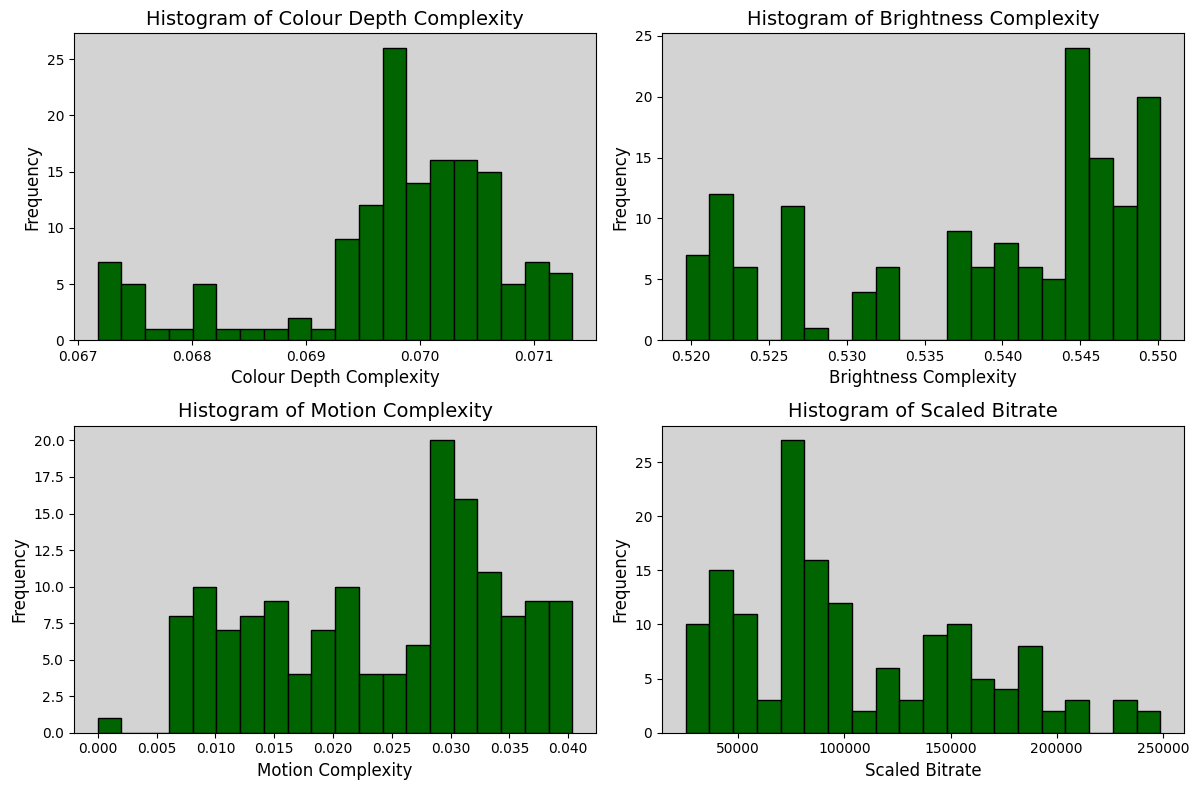

In [6]:
columns_to_plot = ['Colour Depth Complexity', 'Brightness Complexity', 'Motion Complexity', 'Scaled Bitrate']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(columns_to_plot):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    venice[column].plot(kind='hist', ax=ax, bins=20, color='darkgreen', edgecolor='black')
    
    ax.set_facecolor('lightgrey')
    ax.set_title(f'Histogram of {column}', fontsize=14)
    ax.set_xlabel(column, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    
if len(columns_to_plot) < 4:
    fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()


In [7]:
venice.head()

,Colour Depth Complexity,Brightness Complexity,Motion Complexity,Average,Previous Bitrate,Scaling Factor,Scaled Bitrate
0,0.068176,0.546909,0.000000,0.205028,1244160.0,0.000000,103297.0
1,0.068119,0.546381,0.026769,0.213756,1244160.0,0.123920,154176.0
2,0.067841,0.546573,0.021580,0.211998,1244160.0,0.098957,123118.0
3,0.067551,0.546591,0.018243,0.210795,1244160.0,0.081878,101870.0
4,0.067488,0.545860,0.016499,0.209949,1244160.0,0.069865,86924.0


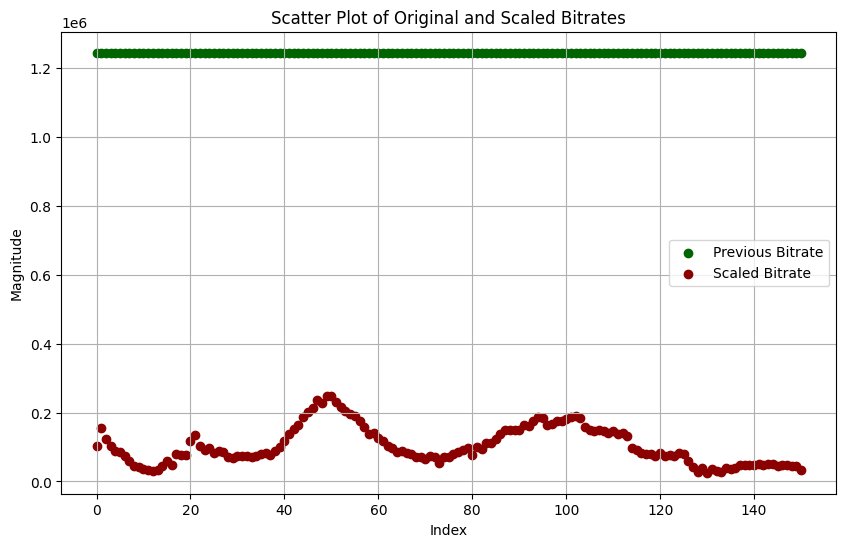

In [8]:
columns_to_plot = ['Previous Bitrate', 'Scaled Bitrate']
colors = ['darkgreen', 'darkred']

plt.figure(figsize=(10, 6))

for i, column in enumerate(columns_to_plot):
    plt.scatter(venice.index, venice[column], label=column, c=colors[i])

plt.title('Scatter Plot of Original and Scaled Bitrates')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.legend()

plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

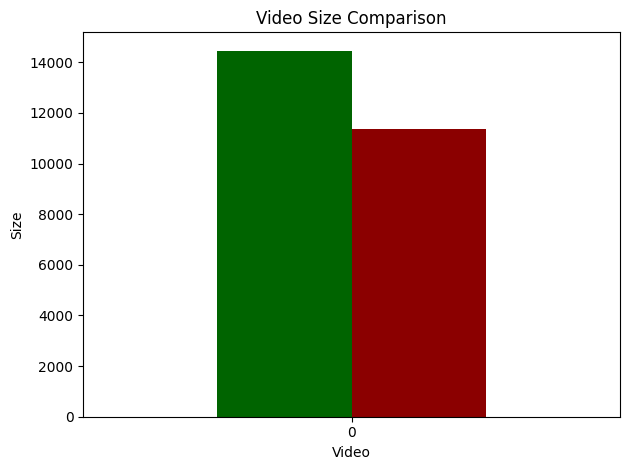

In [9]:
data = pd.DataFrame({'Previous Video Size': [14463], 'New Video Size': [11382]})

plt.figure(figsize=(10, 6))
data.plot(kind='bar', legend=False, color=['darkgreen', 'darkred'])

plt.title('Video Size Comparison')
plt.xlabel('Video')
plt.ylabel('Size')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

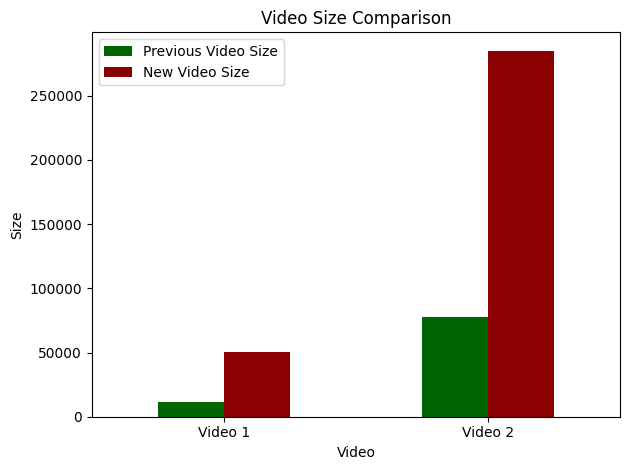

In [10]:
data = pd.DataFrame({'Previous Video Size': [11463, 77300], 'New Video Size': [50147, 285191]})

plt.figure(figsize=(10, 6))
ax = data.plot(kind='bar', color=['darkgreen', 'darkred'])

plt.title('Video Size Comparison')
plt.xlabel('Video')
plt.ylabel('Size')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Video 1', 'Video 2'])

plt.legend(['Previous Video Size', 'New Video Size'])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


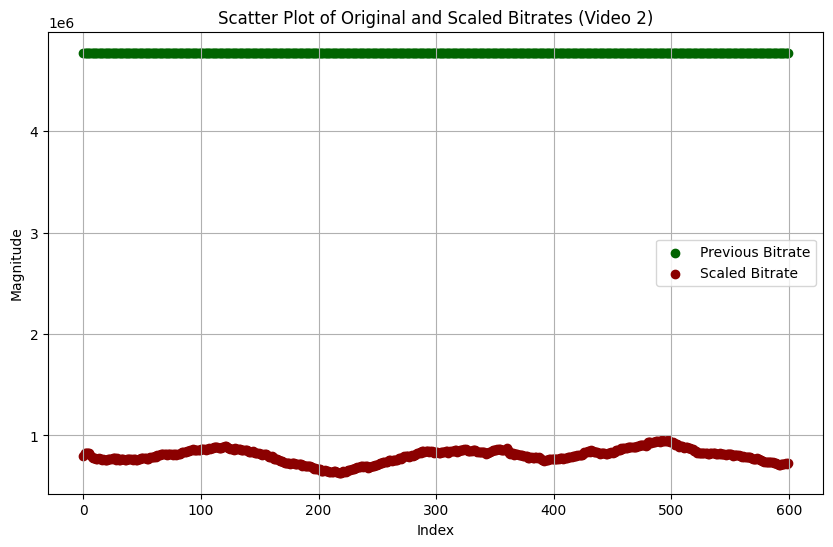

In [11]:
columns_to_plot = ['Previous Bitrate', 'Scaled Bitrate']
colors = ['darkgreen', 'darkred']

plt.figure(figsize=(10, 6))

for i, column in enumerate(columns_to_plot):
    plt.scatter(water.index, water[column], label=column, c=colors[i])

plt.title('Scatter Plot of Original and Scaled Bitrates (Video 2)')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.legend()

plt.grid(True)
plt.show()


In [12]:
venice.describe()

,Colour Depth Complexity,Brightness Complexity,Motion Complexity,Average,Previous Bitrate,Scaling Factor,Scaled Bitrate
count,151.000000,151.000000,151.000000,151.000000,151.0,151.000000,151.000000
mean,0.069788,0.538554,0.024285,0.210876,1244160.0,0.083026,103981.251656
std,0.001009,0.009833,0.010116,0.003125,0.0,0.044371,54552.717531
min,0.067176,0.519674,0.000000,0.205028,1244160.0,0.000000,25269.000000
25%,0.069597,0.531217,0.015228,0.208832,1244160.0,0.054011,69415.500000
50%,0.069942,0.542345,0.027165,0.209903,1244160.0,0.069214,86524.000000
75%,0.070436,0.546255,0.032064,0.213339,1244160.0,0.118003,146815.000000
max,0.071337,0.550131,0.040352,0.219115,1244160.0,0.200000,248832.000000


In [13]:
fishing.describe()

,Colour Depth Complexity,Brightness Complexity,Motion Complexity,Average,Previous Bitrate,Scaling Factor,Scaled Bitrate
count,475.000000,475.000000,475.000000,475.000000,475.0,475.000000,475.000000
mean,0.068109,0.491061,0.067835,0.209002,1244160.0,0.042027,52384.370526
std,0.007397,0.040852,0.047644,0.027897,0.0,0.037650,46796.207489
min,0.049635,0.444946,0.000000,0.177862,1244160.0,0.000000,0.000000
25%,0.064643,0.466190,0.040919,0.192245,1244160.0,0.019412,24172.000000
50%,0.067427,0.474848,0.052404,0.201194,1244160.0,0.031490,39222.000000
75%,0.070278,0.504047,0.079508,0.215385,1244160.0,0.050642,63007.000000
max,0.088177,0.650514,0.298085,0.326052,1244160.0,0.200000,248832.000000


In [14]:
columns_to_analyze = ['Brightness Complexity', 'Colour Depth Complexity', 'Motion Complexity', 'Average']

for column in columns_to_analyze:
    mean_value = venice[column].mean()
    std_deviation = venice[column].std()
    coefficient_of_variation = (std_deviation / mean_value) * 100

    print(f"Coefficient of Variation for Venice {column}: {coefficient_of_variation:.2f}%\n")

for column in columns_to_analyze:
    mean_value = fishing[column].mean()
    std_deviation = fishing[column].std()
    coefficient_of_variation = (std_deviation / mean_value) * 100

    print(f"Coefficient of Variation for Fishing {column}: {coefficient_of_variation:.2f}%\n")

for column in columns_to_analyze:
    mean_value = water[column].mean()
    std_deviation = water[column].std()
    coefficient_of_variation = (std_deviation / mean_value) * 100

    print(f"Coefficient of Variation for Water {column}: {coefficient_of_variation:.2f}%\n")

Coefficient of Variation for Venice Brightness Complexity: 1.83%

Coefficient of Variation for Venice Colour Depth Complexity: 1.45%

Coefficient of Variation for Venice Motion Complexity: 41.66%

Coefficient of Variation for Venice Average: 1.48%

Coefficient of Variation for Fishing Brightness Complexity: 8.32%

Coefficient of Variation for Fishing Colour Depth Complexity: 10.86%

Coefficient of Variation for Fishing Motion Complexity: 70.24%

Coefficient of Variation for Fishing Average: 13.35%

Coefficient of Variation for Water Brightness Complexity: 1.20%

Coefficient of Variation for Water Colour Depth Complexity: 2.31%

Coefficient of Variation for Water Motion Complexity: 6.85%

Coefficient of Variation for Water Average: 1.63%



In [15]:
columns_to_analyze = ['Brightness Complexity', 'Colour Depth Complexity', 'Motion Complexity']

for column in columns_to_analyze:
    mean_value = fishing[column].max() - fishing[column].min()
    
    print(f"Range for {column}: {round(mean_value, 3)}")

Range for Brightness Complexity: 0.206
Range for Colour Depth Complexity: 0.039
Range for Motion Complexity: 0.298


In [16]:
columns_to_analyze = ['Brightness Complexity', 'Colour Depth Complexity', 'Motion Complexity']

for column in columns_to_analyze:
    mean_value = water[column].mean()
    std_deviation = water[column].std()
    coefficient_of_variation = (std_deviation / mean_value) * 100

    print(f"Coefficient of Variation for Water Fountain {column}: {coefficient_of_variation:.2f}%")

Coefficient of Variation for Water Fountain Brightness Complexity: 1.20%
Coefficient of Variation for Water Fountain Colour Depth Complexity: 2.31%
Coefficient of Variation for Water Fountain Motion Complexity: 6.85%
